In [1]:
####
# This notebook predicts housing prices in city of London using dataset provided by HM Land Registry 
# Objective is to build a baseline model and compare against open-source AutoML libraries
#
# Author : Harshal Patil
####

In [2]:
#import necessary modules
import numpy as np
import pandas as pd
import scipy as sc
import sklearn as skl
import matplotlib.pyplot as plt
import math as mth
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
#a tiny function to print top and bottom row from dataframe.
#good way to quickly inspect dataframe
def df2row(x,lines=1):
    return pd.concat([x.head(lines),x.tail(lines)])

In [10]:
###### LONDON HOUSING PRICE PREDICTION
# Data Location:
# https://data.gov.uk/dataset/4c9b7641-cf73-4fd9-869a-4bfeed6d440e/hm-land-registry-price-paid-data
#
# Data for 2018 Housing Transactions:
# http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2018.csv

#!pwd
# Download file on Linux
#!wget http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2018.csv

#macOS    
#!curl -O http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2018.csv


/Users/harshalpatil/Desktop
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0


In [11]:
# the heading definitions are at 
#https://www.gov.uk/guidance/about-the-price-paid-data#explanations-of-column-headers-in-the-ppd
#download the heading definitions as reference in this project

#!pwd
#!wget https://www.gov.uk/guidance/about-the-price-paid-data#explanations-of-column-headers-in-the-ppd

#macOS
#!curl https://www.gov.uk/guidance/about-the-price-paid-data#explanations-of-column-headers-in-the-ppd > dataexplain.html

/Users/harshalpatil/Desktop
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  101k  100  101k    0     0   761k      0 --:--:-- --:--:-- --:--:--  761k


In [12]:
# check raw file lines - there is no heading present
#
#!cat pp-2018.csv | head -n5

In [9]:
###### Exploratory Data Analysis (EDA)

In [14]:
#read dataset in memory
#assign column names as per data definition document provided (names are missing in csv)
#parse dates and set a datetimeindex in dataframe using it - to segment dataset by dates easily
file = "pp-2018.csv"
df = pd.read_csv(file,names=["id","price","date","postcode","type","new","lease","paon","saon",
                                         "street","locality","town","district","county","category","status"],
                parse_dates=["date"],index_col="date")

print("Dataset loaded in memory")
print("Dataset rows x columns",df.shape)

Dataset loaded in memory
Dataset rows x columns (1023150, 15)


In [15]:
#cut the memory requirement - filter the dataset immediately to only focus on London data
#city/town (i.e. the fieldname town) has "london" in it. 
#Adjust case to ensure all data picked up.
filter_london = df.town.apply(lambda x: "london" in x.lower())
df = df[filter_london]
#check top and bottom row in the dataframe
df2row(df)


,id,price,postcode,type,new,lease,paon,saon,street,locality,town,district,county,category,status
date,,,,,,,,,,,,,,,
2018-05-25,{7011B109-D879-8ED6-E053-6B04A8C075C1},1205000,SW13 0NZ,T,N,F,6,NaN,CHARLES STREET,NaN,LONDON,RICHMOND UPON THAMES,GREATER LONDON,A,A
2018-10-31,{7C2D0700-4940-4963-E053-6B04A8C07B97},2461000,SW15 6NW,S,N,F,16,NaN,CAMPION ROAD,NaN,LONDON,WANDSWORTH,GREATER LONDON,A,A


In [16]:
#check data coverage across years and months
pd.crosstab(df.index.year, df.index.month,margins=True)

col_0,1,2,3,4,5,6,7,8,9,10,11,12,All
row_0,,,,,,,,,,,,,
2018,5058,4725,5573,4850,5223,6205,6150,6288,5605,5709,5803,5002,66191
All,5058,4725,5573,4850,5223,6205,6150,6288,5605,5709,5803,5002,66191


In [17]:
#do quick check on unique values counts in categorical fields
#there is good spread across values in type, new, lease 
df.loc[:,["type","new","lease","category","status"]].apply(pd.Series.value_counts)

,type,new,lease,category,status
A,NaN,NaN,NaN,51342.0,66191.0
B,NaN,NaN,NaN,14849.0,NaN
D,1034.0,NaN,NaN,NaN,NaN
F,42315.0,NaN,20374.0,NaN,NaN
L,NaN,NaN,45817.0,NaN,NaN
N,NaN,52767.0,NaN,NaN,NaN
O,5571.0,NaN,NaN,NaN,NaN
S,3696.0,NaN,NaN,NaN,NaN
T,13575.0,NaN,NaN,NaN,NaN
Y,NaN,13424.0,NaN,NaN,NaN


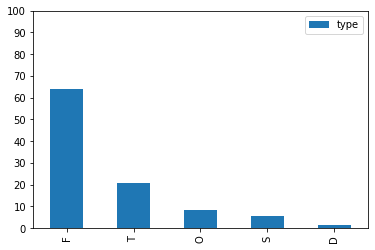

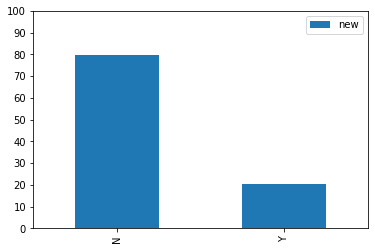

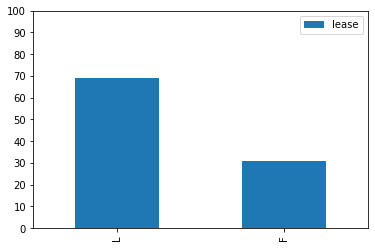

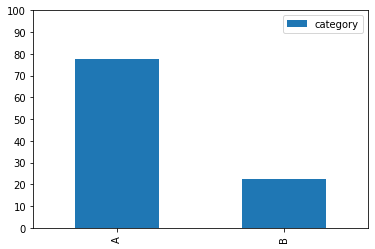

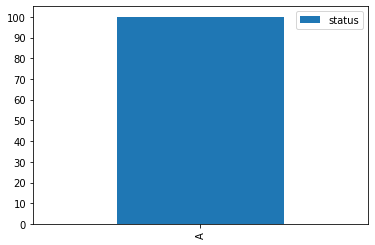

In [18]:
#check variation in the different categories to pick features that we can learn from
for f in ["type","new","lease","category","status"]:
    counts = df.loc[:,[f]].apply(pd.Series.value_counts)
    counts = (counts/counts.loc[:,f].sum())*100
    
    counts.plot(kind='bar',yticks=range(0,110,10))


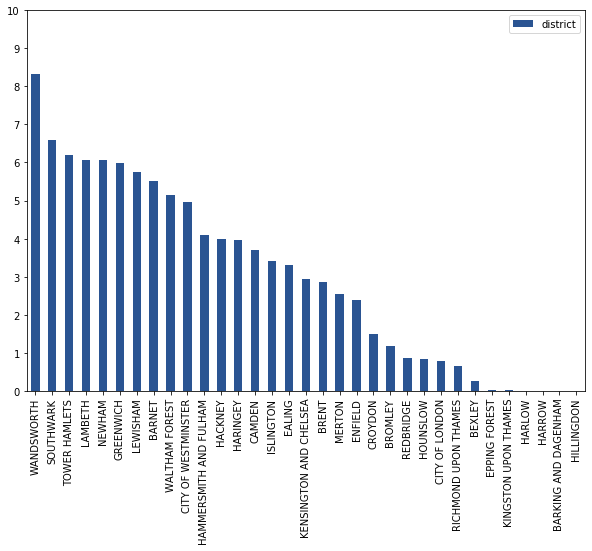

In [21]:
#check the spread in districts (london burroughs) as well
distcnt = df.district.value_counts()
distcnt = distcnt/distcnt.sum() * 100
distcnt.plot(kind='bar',yticks=range(0,11,1),color="#2a5492",figsize=(10,7),legend=True)    


In [23]:
#postcode is highly potent categorical feature to potentially capture lot of variation in home pricing - 
#however there are some data quality issues such as reallocation of postcodes which is not reflected back 
#into the current dataset
#this is one of the longer term model optimization path - currently just check how many unique values are there
df.postcode.unique().shape

(32134,)

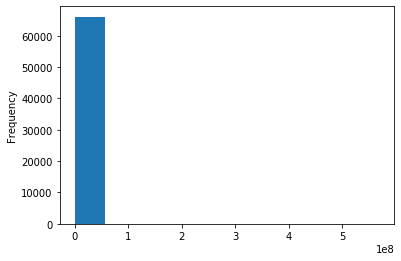

In [24]:
#check the dependent variable - home price - distribution
#convert to a make it normal - if necessary
#Histogram of price - skewed with long right tail
df.price.plot.hist()


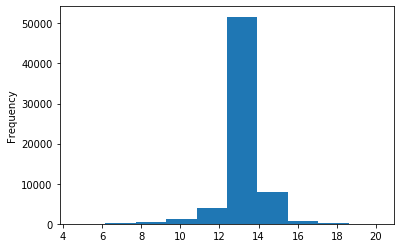

In [25]:
#Histogram shows a highly skewed distribution - which is expected for price. 
#Only handful would pay exceptionally high prices - while most will be in the lower bins paying average price.
#A log transformation will convert price into a closer to normal distribution. 
#This can then be modeled as dependent variable
#After making a forecast we undo log by passing thru exponential function

df["logprice"] = df.price.apply(mth.log)
df.logprice.plot.hist()


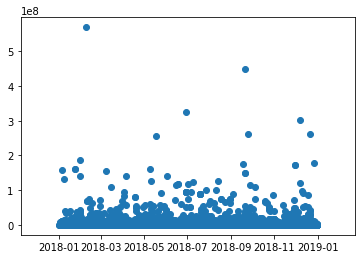

In [26]:
#visualize raw and log trend over years
plt.scatter(x=df.index,y=df.price)


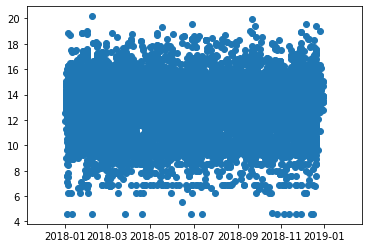

In [27]:
# Flat to slightly increasing trend over 2018
plt.scatter(x=df.index,y=df.logprice)



In [28]:
#nYear is a numeric feature that shows years since timeseries began. 
#Since each unit change in this feature is always equal to one year it is a numeric variable
#This representation allows to forecast into future time periods as well.
#df["year"] = df.index.year
df["nyear"] = df.index.year - 2018
df["quarter"] = df.index.quarter
df2row(df)

,id,price,postcode,type,new,lease,paon,saon,street,locality,town,district,county,category,status,logprice,nyear,quarter
date,,,,,,,,,,,,,,,,,,
2018-05-25,{7011B109-D879-8ED6-E053-6B04A8C075C1},1205000,SW13 0NZ,T,N,F,6,NaN,CHARLES STREET,NaN,LONDON,RICHMOND UPON THAMES,GREATER LONDON,A,A,14.001990,0,2
2018-10-31,{7C2D0700-4940-4963-E053-6B04A8C07B97},2461000,SW15 6NW,S,N,F,16,NaN,CAMPION ROAD,NaN,LONDON,WANDSWORTH,GREATER LONDON,A,A,14.716078,0,4


In [29]:
#drop fields that are not candidates for independent variables/features such as address details that are too granular.
#also drop the regular price and keep logprice instead
#do it inplace to better manage memory
df.drop(columns=["id","price","postcode","paon","saon","street","locality","town","county",
                "status"],inplace=True)
df2row(df)

,type,new,lease,district,category,logprice,nyear,quarter
date,,,,,,,,
2018-05-25,T,N,F,RICHMOND UPON THAMES,A,14.001990,0,2
2018-10-31,S,N,F,WANDSWORTH,A,14.716078,0,4


In [30]:
# FEATURE SELECTION - BUILD UNIVARIATE MODELS AND PICK THE BEST FIT VARIABLES.

candidatefeatures = ["nyear","quarter","type","new","lease","district"]
candidatefcategorical = [False, True, True, True, True, True]
dependentfeature = "logprice"

#for categorical variables - dummay coding ie dummy variables will be generated for each feature to test out.
#lists to store coeff and perf measurements for models by individual candidate features
featurecount = 0

coeff = []
mse = []
r2 = []
rankorder = []
rankorderp = []

# Build univariate models to identify most promising features.
# Use the 3 most promising features to get the base model

for feature, iscategorical in zip(candidatefeatures, candidatefcategorical):

    Xlist = []
    ylist = []

    dset = df
    
    X = dset.loc[:,feature]
    y = dset.logprice
    
    # internal stuff - handle weird behaviors of packages
    X = pd.DataFrame({feature:X}) #series to dataframe
    y = pd.DataFrame({dependentfeature:y})
    
    if iscategorical:
        X = X[feature].apply(str) #so dummies will work always
        # convert categorical feature into dummy coding and have k-1 categories as reqd for modeling.
        X = pd.get_dummies(X,prefix=feature,drop_first=True)
   
    #train
    Xlist.append(X.iloc[dset.index.month<10,:])
    ylist.append(y.iloc[dset.index.month<10,:])
    
    #test
    Xlist.append(X.iloc[dset.index.month>9,:])
    ylist.append(y.iloc[dset.index.month>9,:])

    
    #instantiate and train a liner regression to estimate logprice
    model=LinearRegression()
    model.fit(Xlist[0],ylist[0])
    ypred = model.predict(Xlist[1])

    coeff.append(model.coef_)
    mse.append(mean_squared_error(ylist[1], ypred))
    r2.append(r2_score(ylist[1], ypred))


featureseldf = pd.DataFrame([candidatefcategorical,r2,mse,rankorder,rankorderp],columns=candidatefeatures,
                            index=["IsCategorical","R2","MSE","RankOrder","RankOrderp"])
print(featureseldf)


                     nyear      quarter       type         new      lease  \
IsCategorical        False         True       True        True       True   
R2            -1.80282e-09 -4.59036e-06  0.0925876  0.00252878  0.0366001   
MSE               0.932633     0.932637   0.846282    0.930274   0.898498   
RankOrder             None         None       None        None       None   
RankOrderp            None         None       None        None       None   

                district  
IsCategorical       True  
R2             0.0775072  
MSE             0.860347  
RankOrder           None  
RankOrderp          None  


In [31]:
# fit model to Type, district, Lease (Freehold/Leasehold), New/Old property
# annual trend not applicable since training data has 1 year
# quarterly seasonality is not useful in improving R2 or reducing MSE

dset = pd.get_dummies(dset,
                      prefix=["type","new","lease","district"],
                      columns =  ["type","new","lease","district"], 
                      drop_first=True)
dset.drop(columns=["category","nyear","quarter"],
         inplace=True)

X_train = dset[dset.index.month < 10].drop(columns=["logprice"])
y_train = dset[dset.index.month < 10].logprice

X_test = dset[dset.index.month > 9].drop(columns=["logprice"])
y_test = dset[dset.index.month > 9].logprice

#instantiate and train a liner regression to estimate logprice
model=LinearRegression()
model.fit(X_train,y_train)
ypred = model.predict(X_test)

print(mean_squared_error(y_test, ypred))
print(r2_score(y_test, ypred))
print(X_train.columns)
print(model.coef_)


0.6963070373611756
0.2533961334658762
Index(['type_F', 'type_O', 'type_S', 'type_T', 'new_Y', 'lease_L',
       'district_BARNET', 'district_BEXLEY', 'district_BRENT',
       'district_BROMLEY', 'district_CAMDEN', 'district_CITY OF LONDON',
       'district_CITY OF WESTMINSTER', 'district_CROYDON', 'district_EALING',
       'district_ENFIELD', 'district_EPPING FOREST', 'district_GREENWICH',
       'district_HACKNEY', 'district_HAMMERSMITH AND FULHAM',
       'district_HARINGEY', 'district_HARLOW', 'district_HARROW',
       'district_HILLINGDON', 'district_HOUNSLOW', 'district_ISLINGTON',
       'district_KENSINGTON AND CHELSEA', 'district_KINGSTON UPON THAMES',
       'district_LAMBETH', 'district_LEWISHAM', 'district_MERTON',
       'district_NEWHAM', 'district_REDBRIDGE',
       'district_RICHMOND UPON THAMES', 'district_SOUTHWARK',
       'district_TOWER HAMLETS', 'district_WALTHAM FOREST',
       'district_WANDSWORTH'],
      dtype='object')
[-0.4380381  -1.56962834 -0.47416594 -0.

In [34]:
df2row(df)

,type,new,lease,district,category,logprice,nyear,quarter
date,,,,,,,,
2018-05-25,T,N,F,RICHMOND UPON THAMES,A,14.001990,0,2
2018-10-31,S,N,F,WANDSWORTH,A,14.716078,0,4


In [35]:
####AUTOML TPOT
# convert categorical feature into dummy coding and have k-1 categories as reqd for modeling.
X = pd.get_dummies(df,drop_first=True)
df2row(X)

In [ ]:
#timeseries so carve out manually
X_train = X[X.index.month < 10].drop(columns=["logprice"])
y_train = X[X.index.month < 10].logprice

X_test = X[X.index.month > 9].drop(columns=["logprice"])
y_test = X[X.index.month > 9].logprice


In [36]:
import tpot

tpotm = tpot.TPOTRegressor(generations=5, population_size=100, verbosity=2,
                          scoring='r2')
tpotm.fit(X_train, y_train)
print(tpotm.score(X_test, y_test))
tpotm.export('tpot_boston_pipeline.py')




TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesRegressor(LassoLarsCV(input_matrix, normalize=True), bootstrap=True, max_features=0.3, min_samples_leaf=20, min_samples_split=2, n_estimators=100)
0.2793089749641007
